<a href="https://colab.research.google.com/github/teamsimcoemmai/mmai894/blob/894-Ci/EfficientNet_Ci_with_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install fastai
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from collections import Counter

In [ ]:
import random

import pandas as pd
import scipy.io as sio
import numpy as np

import shutil
from shutil import copyfile

import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.applications.resnet import ResNet50, ResNet152, preprocess_input
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

In [ ]:
os.chdir("/content/drive/My Drive/MMAI 894 Project/Data")
os.listdir()

['car_ims.tgz',
 'df_test.csv',
 'df_train.gsheet',
 'df_total.csv',
 'df_train.csv',
 'df_car_names.csv',
 'car_ims',
 'cars_test.tgz',
 'cars_train.tgz',
 'train',
 'test',
 'cars_test_annos.mat',
 'cars_train_annos.mat',
 'df_total.gsheet',
 'labels_df.csv']

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = '/content/drive/My Drive/MMAI 894 Project/Data/'
labels_df = pd.read_csv('/content/drive/My Drive/MMAI 894 Project/Data/labels_df.csv')
labels_df.head(3)

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,class_name,is_test
0,000001.jpg,112,7,853,717,1,AM General Hummer SUV 2000,0
1,000002.jpg,48,24,441,202,1,AM General Hummer SUV 2000,0
2,000003.jpg,7,4,277,180,1,AM General Hummer SUV 2000,0


In [ ]:
# This Step split the car images into training group and test group. ONLY RUN ONCE!

# train_indexes = labels_df[labels_df['is_test']==0]['filename'].tolist()
# test_indexes = labels_df[labels_df['is_test']==1]['filename'].tolist()

# src_folder = '/content/drive/My Drive/MMAI 894 Project/Data/car_ims/'

# for i in train_indexes:
#   dst_folder = '/content/drive/My Drive/MMAI 894 Project/Data/car_ims/train'
#   new_filename = os.path.join(dst_folder, i)
#   old_filename = os.path.join(src_folder, i)
#   shutil.copy(old_filename, new_filename)
 
# for i in test_indexes:
#   dst_folder = '/content/drive/My Drive/MMAI 894 Project/Data/car_ims/test'
#   new_filename = os.path.join(dst_folder, i)
#   old_filename = os.path.join(src_folder, i)
#   shutil.copy(old_filename, new_filename)

In [ ]:
def get_data(SZ:int=299, do_cutout:bool=False, p_cutout:float=0.75):
    SEED = 42
    LABEL = 'class_name'
    # LABEL = 'class_id'
    PATH = '/content/drive/My Drive/MMAI 894 Project/Data/car_ims/'


    if do_cutout == True:
        cutout_tfm = cutout(n_holes=(1,2), length=(100, 100), p=p_cutout)
        car_tfms = get_transforms(xtra_tfms=[cutout_tfm])
    else: car_tfms = get_transforms()

    #tfms = get_transforms()

    trn_labels_df = labels_df.loc[labels_df['is_test']==0, ['filename', 'class_name', 'class_id']].copy()
    tst_labels_df = labels_df.loc[labels_df['is_test']==1, ['filename', 'is_test','class_name','class_id']].copy()


    src = (ImageList.from_df(trn_labels_df, path = PATH, folder='train', cols='filename')
                        .split_by_rand_pct(valid_pct=0.2, seed=SEED)
                        .label_from_df(cols=LABEL))

    data = (src.transform(car_tfms, 
                          size=SZ,  
                          resize_method=ResizeMethod.SQUISH, 
                          padding_mode='reflection')
                .databunch()
                .normalize(imagenet_stats))
    
    # Get test data
    TEST_SZ = 299
    src_test = (ImageList.from_df(labels_df, path = PATH, cols='filename')
    # the 'is_test' column has values of 1 for the test set
                              .split_from_df(col='is_test')
                              .label_from_df(cols=LABEL))

    data_test = (src_test.transform(car_tfms, 
                                    size=SZ,  
                                    resize_method=ResizeMethod.SQUISH, 
                                    padding_mode='reflection')
                .databunch()
                .normalize(imagenet_stats))
    
    return data, data_test, src, src_test, car_tfms

data, data_test, src, src_test, car_tfms = get_data(do_cutout=False)

In [ ]:
# By @muellerzr on the fastai forums:
# https://forums.fast.ai/t/meet-mish-new-activation-function-possible-successor-to-relu/53299/133       

from fastai.callbacks import *

def FlatCosAnnealScheduler(learn, lr:float=4e-3, tot_epochs:int=1, moms:Floats=(0.95,0.999),
                          start_pct:float=0.72, curve='cosine'):
    "Manage FCFit trainnig as found in the ImageNette experiments"
    n = len(learn.data.train_dl)
    anneal_start = int(n * tot_epochs * start_pct)
    batch_finish = ((n * tot_epochs) - anneal_start)
    if curve=="cosine":
        curve_type=annealing_cos
    elif curve=="linear":
        curve_type=annealing_linear
    elif curve=="exponential":
        curve_type=annealing_exp
    else:
        raiseValueError(f"annealing type not supported {curve}")

    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr).schedule_hp('mom', moms[0])
    phase1 = TrainingPhase(batch_finish).schedule_hp('lr', lr, anneal=curve_type).schedule_hp('mom', moms[1])
    phases = [phase0, phase1]
    return GeneralScheduler(learn, phases)
                
def fit_fc(learn:Learner, tot_epochs:int=None, lr:float=defaults.lr,  moms:Tuple[float,float]=(0.95,0.85), start_pct:float=0.72,
                  wd:float=None, callbacks:Optional[CallbackList]=None, show_curve:bool=False)->None:
    "Fit a model with Flat Cosine Annealing"
    max_lr = learn.lr_range(lr)
    callbacks = listify(callbacks)
    callbacks.append(FlatCosAnnealScheduler(learn, lr, moms=moms, start_pct=start_pct, tot_epochs=tot_epochs))
    learn.fit(tot_epochs, max_lr, wd=wd, callbacks=callbacks)

In [ ]:
def save_metrics_to_csv(exp_name, run_count, learn, metrics):
    for m in metrics:
        name = f'{m}_{exp_name}_run{str(run_count)}_2021-03_23'

        ls = []
        if m == 'val_loss_and_acc':
            acc = []
            for l in learn.recorder.metrics:
                 acc.append(l[0].item())
            ls = learn.recorder.val_losses 

            d = {name: ls, 'acc': acc}
            df = pd.DataFrame(d)
            #df.columns = [name, 'acc']
        elif m == 'trn_loss':
            for l in learn.recorder.losses:
                ls.append(l.item())
            df = pd.DataFrame(ls)
            df.columns = [name]

        df.to_csv(f'{name}_{m}.csv')
        print(df.head())

In [ ]:
!pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=b6175307723f7f93517e535b9023df9695cb1229cf5ab7c65b3a46a695eab6e8
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet as MEfficientNet

effnet_b3 = 'efficientnet-b3'
def getMishModel(data, model_name):
    model = MEfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(1536, data.c)
    return model

mish_model = getMishModel(data, effnet_b3) 

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


In [ ]:
# os.chdir("/content/drive/My Drive/MMAI 894 Project/")
# !git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
os.chdir("/content/drive/My Drive/MMAI 894 Project/Ranger-Deep-Learning-Optimizer")
!pip install -e . 

Obtaining file:///content/drive/My%20Drive/MMAI%20894%20Project/Ranger-Deep-Learning-Optimizer
  Running setup.py develop for ranger


In [ ]:
from ranger import Ranger  # this is from ranger.py
from ranger import RangerVA  # this is from ranger913A.py
from ranger import RangerQH  # this is from rangerqh.py

In [ ]:
optimizer = partial(Ranger)
exp_name = 'mefficient_b3_ranger913A_40e_15e4_wd1e-3_10pct_start'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data_test.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-3,
                opt_func=optimizer,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

fit_fc(learn, tot_epochs=30, lr=15e-4, start_pct=0.10, wd=1e-3, show_curve=False)

learn.save(f'exp_{exp_name}_run{run_count}')

# SAVE METRICS
save_metrics_to_csv(exp_name, run_count, learn, metrics)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,accuracy,time
0,3.686364,2.865934,0.456038,37:40
1,1.923422,1.734385,0.747668,07:12
2,1.519987,1.551558,0.797413,07:03
3,1.361588,1.473365,0.828131,07:05
4,1.240190,1.400849,0.856485,07:05
5,1.156047,1.376897,0.859843,07:11
6,1.155731,1.446694,0.846537,07:08
7,1.147681,1.346742,0.872528,07:14
8,1.087431,1.350893,0.877627,07:16
9,1.057441,1.280920,0.892178,07:20


   trn_loss_mefficient_b3_ranger913A_40e_15e4_wd1e-3_10pct_start_run1_2019-09_04
0                                           5.254241                            
1                                           5.297341                            
2                                           5.278513                            
3                                           5.267616                            
4                                           5.274420                            
   val_loss_and_acc_mefficient_b3_ranger913A_40e_15e4_wd1e-3_10pct_start_run1_2019-09_04       acc
0                                           2.865934                                      0.456038
1                                           1.734385                                      0.747668
2                                           1.551558                                      0.797413
3                                           1.473365                                      0.828131
4                  

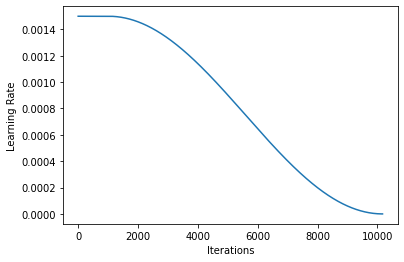

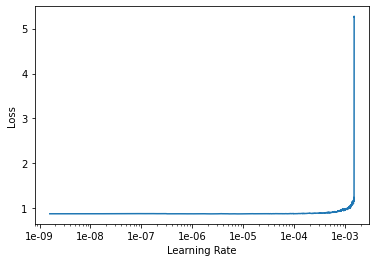

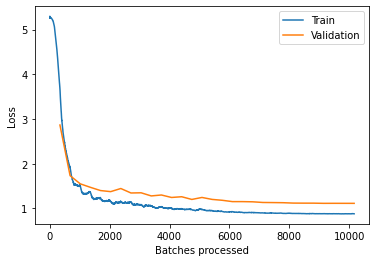

In [ ]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

In [ ]:
learn.summary()

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 301, 301]        0          False     
______________________________________________________________________
BatchNorm2d          [40, 150, 150]       80         True      
______________________________________________________________________
ZeroPad2d            [40, 152, 152]       0          False     
______________________________________________________________________
BatchNorm2d          [40, 150, 150]       80         True      
______________________________________________________________________
Identity             [40, 1, 1]           0          False     
______________________________________________________________________
Identity             [10, 1, 1]           0          False     
______________________________________________________________________
Identity             [40, 150, 150]       0          False     
_________________________________________________

# **Test**

In [ ]:
tst_labels_df = labels_df.loc[labels_df['is_test']==1, ['filename', 'is_test','class_name','class_id']].copy()
tst_labels_df

,filename,is_test,class_name,class_id
45,000046.jpg,1,AM General Hummer SUV 2000,1
46,000047.jpg,1,AM General Hummer SUV 2000,1
47,000048.jpg,1,AM General Hummer SUV 2000,1
48,000049.jpg,1,AM General Hummer SUV 2000,1
49,000050.jpg,1,AM General Hummer SUV 2000,1
...,...,...,...,...
16180,016181.jpg,1,smart fortwo Convertible 2012,196
16181,016182.jpg,1,smart fortwo Convertible 2012,196
16182,016183.jpg,1,smart fortwo Convertible 2012,196
16183,016184.jpg,1,smart fortwo Convertible 2012,196


In [ ]:
def generate_test_data(SZ:int=299, do_cutout:bool=False):
    LABEL = 'class_name'
    PATH = '/content/drive/My Drive/MMAI 894 Project/Data/car_ims/'

    tst_labels_df = labels_df.loc[labels_df['is_test']==1, ['filename', 'is_test','class_name','class_id']].copy()

    test_car_tfms = get_transforms()

    # Get test data
    TEST_SZ = 299
    test_src = (ImageList.from_df(tst_labels_df, path = PATH, folder='test',cols='filename')
                              .split_none()
                              .label_from_df(cols=LABEL))


    test_set = (test_src.transform(test_car_tfms, 
                                    size=SZ,  
                                    resize_method=ResizeMethod.SQUISH, 
                                    padding_mode='reflection')
                .databunch()
                .normalize(imagenet_stats))
    
    return test_set, test_car_tfms
test_set, test_car_tfms = generate_test_data(do_cutout=False)


In [ ]:
test = test_set.train_ds
test

LabelList (8041 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000
Path: /content/drive/My Drive/MMAI 894 Project/Data/car_ims

In [ ]:
data

ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000
Path: /content/drive/My Drive/MMAI 894 Project/Data/car_ims;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Spyker C8 Coupe 2009,Audi A5 Coupe 2012,Suzuki SX4 Sedan 2012,Ford Mustang Convertible 2007,Dodge Durango SUV 2007
Path: /content/drive/My Drive/MMAI 894 Project/Data/car_ims;

Test: None

In [ ]:
data_test

ImageDataBunch;

Train: LabelList (8144 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000
Path: /content/drive/My Drive/MMAI 894 Project/Data/car_ims;

Valid: LabelList (8041 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000
Path: /content/drive/My Drive/MMAI 894 Project/Data/car_ims;

Test: None

In [ ]:
optimizer = partial(Ranger)
exp_name = 'Efficient_Test'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data_test.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data, 
                model=mish_model,
                wd = 1e-3,
                opt_func=optimizer,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

In [ ]:
learn.load('exp_mefficient_b3_ranger913A_40e_15e4_wd1e-3_10pct_start_run1')

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
set state called


Learner(data=ImageDataBunch;

Train: LabelList (8144 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000
Path: /content/drive/My Drive/MMAI 894 Project/Data/car_ims;

Valid: LabelList (8041 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000
Path: /content/drive/My Drive/MMAI 894 Project/Data/car_ims;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.01000000000

In [ ]:
test = data_test.valid_ds
test

LabelList (8041 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000
Path: /content/drive/My Drive/MMAI 894 Project/Data/car_ims

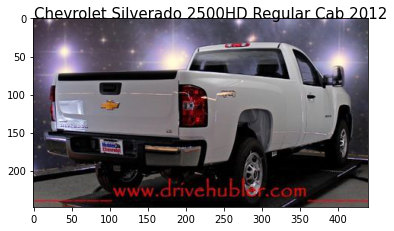

In [ ]:
test_set_path = "/content/drive/My Drive/MMAI 894 Project/Data/car_ims/"

image_index = 99
image_file_name = labels_df['filename'][image_index]

test_image_path = test_set_path + image_file_name
#test_image_path
test_image = plt.imread(test_image_path) 

label = labels_df['class_name'][image_index]

plt.text(0,0,label, fontsize=15, color='black')
plt.imshow(test_image)

In [ ]:
pred = learn.predict(open_image(test_image_path))
pred_df = pd.DataFrame(pred)
#pred_df.set_index('key').join(other.set_index('key'))
pred_df[0]
# predicted_class_name = pred_df[0]
# predicted_class_name

0          Chevrolet Silverado 2500HD Regular Cab 2012
1                                           tensor(70)
2    [tensor(0.0516), tensor(0.2157), tensor(0.2380...
Name: 0, dtype: object

In [ ]:
pred_df = pd.DataFrame(pred[1])
pred_df[0] += 1
pred_df

,0
0,1
1,1
2,1
3,1
4,1
...,...
6511,196
6512,196
6513,196
6514,196


In [ ]:
tst_labels_df = labels_df.loc[labels_df['is_test']==1, ['class_id']].copy()
tst_labels_df

In [ ]:
compare_df =tst_labels_df.compare(pred_df)

ValueError: ignored

In [ ]:
data_test

NameError: ignored

In [ ]:
os.chdir("/content/drive/My Drive/Simcoe/894/Car dataset")
os.listdir()

['cars_test',
 'cars_train.tgz',
 'cars_test.tgz',
 'devkit',
 'df_test.csv',
 'df_train.csv',
 'train_set',
 'val_set',
 'archive',
 'Copy of df_car_names.csv',
 'cropped_raw',
 'test_set',
 'new',
 'df_total.csv',
 'df_test_new.csv',
 'models']

In [ ]:
data = ImageDataBunch.from_folder('/content/drive/My Drive/Simcoe/894/Car dataset','train_set','val_set','test_set',
                                  ds_tfms=get_transforms(do_flip=False, 
                                                         flip_vert=True, 
                                                         p_affine=0.75, # Default value
                                                         max_rotate=5.0, 
                                                         max_zoom=1.1,
                                                         max_warp=0.2,
                                                         p_lighting=0.75, # Defalut value 
                                                         max_lighting=0.2,                                                                                                                  ),
                                                         size=224,
                                                         bs=32).normalize(imagenet_stats)

In [ ]:
optimizer = partial(Ranger)
exp_name = 'Efficient_Test'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data, 
                model=mish_model,
                wd = 1e-3,
                opt_func=optimizer,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

In [ ]:
os.chdir("/content/drive/My Drive/MMAI 894 Project/Data/car_ims/models")
os.listdir()

['exp_mefficient_b3_ranger913A_40e_15e4_wd1e-3_10pct_start_run1.pth']

In [ ]:
learn.load('exp_mefficient_b3_ranger913A_40e_15e4_wd1e-3_10pct_start_run1')

FileNotFoundError: ignored

In [ ]:
learn.get_preds(data)

[tensor([[ 9.8438e+00, -1.9072e+00, -6.6467e-02,  ..., -4.6436e-01,
          -7.9492e-01, -6.1035e-01],
         [ 8.0781e+00,  6.8506e-01,  4.2065e-01,  ..., -4.8790e-03,
           1.3269e-01,  4.1064e-01],
         [ 9.7266e+00, -1.1436e+00,  5.6250e-01,  ..., -4.3091e-01,
          -1.1084e-01, -1.4160e-01],
         ...,
         [ 7.2021e-02, -6.5625e-01, -2.7441e-01,  ...,  1.2793e-01,
           1.3831e-01,  1.0320e+01],
         [-3.0347e-01, -1.3018e+00, -4.7241e-01,  ...,  7.8491e-02,
           2.2754e-01,  1.1086e+01],
         [ 3.0493e-01, -1.8701e-01, -2.3291e-01,  ...,  3.9551e-01,
           2.9053e-01,  9.5703e+00]]),
 tensor([  0,   0,   0,  ..., 195, 195, 195])]

In [ ]:
data

ImageDataBunch;

Train: LabelList (6515 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
14,14,14,14,14
Path: /content/drive/My Drive/Simcoe/894/Car dataset;

Valid: LabelList (1629 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,3,3,3,3
Path: /content/drive/My Drive/Simcoe/894/Car dataset;

Test: LabelList (8041 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/Simcoe/894/Car dataset

In [ ]:
prediction, y = learn.get_preds(DatasetType.Test)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [ ]:
y_pred = torch.argmax(prediction, dim=1)
y_pred

tensor([  0,   0,   0,  ..., 195, 195, 195])

In [ ]:
df_test = tst_labels_df
feature_list = ['actual_class','predicted_class']
valid = pd.DataFrame(0, index=df_test.index, columns=feature_list)
valid['actual_class'] = df_test['class_id']
valid['predicted_class'] = y_pred+1

valid['diff'] = np.where(valid['actual_class'] == valid['predicted_class'],1,0)
accuracy = valid['diff'].sum()/valid.shape[0]*100
accuracy

25.80524810346972